<a href="https://colab.research.google.com/github/ReshmaRaj13/Image_segmentation/blob/main/LandCover_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install patchify

In [3]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt

In [4]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
import tensorflow as tf

In [ ]:
!pip install -U segmentation_models

In [ ]:
!unzip Landcover_segmentation.zip

In [ ]:
for path, subdirs, files in os.walk('/content/Semantic segmentation dataset'):
  dir_name = path.split(os.path.sep)[-1]
  if dir_name == 'masks':
    images = os.listdir(path)
    for image_name in images:
      if (image_name.endswith('.png')):
         print(image_name)


In [8]:
image_patch_size = 256

In [9]:
minmaxscaler = MinMaxScaler()

In [10]:
dataset_root_folder = '/content/Semantic segmentation dataset'
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}', 1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            if image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
             # print(type(individual_patched_mask))
              mask_dataset.append(individual_patched_mask)

In [11]:
len(image_dataset)

945

In [12]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [13]:
print(len(mask_dataset))

945


In [ ]:
random_image_id = np.random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [ ]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

In [ ]:
mask_dataset.shape[0]

In [17]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [18]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [ ]:
print(np.shape(labels))

In [ ]:
np.unique(labels)

In [ ]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

In [22]:
total_classes = len(np.unique(labels))


In [23]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [24]:
master_trianing_dataset = image_dataset

In [25]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [27]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [28]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [29]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [30]:
def multi_unet_model(n_classes = 5, image_height = 256, image_width = 256, image_channels = 1):
  input = Input((image_height, image_width, image_channels))

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[input], outputs=[outputs])
  return model


In [31]:
metrics = ["accuracy", jaccard_coef]

In [32]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [33]:
model = get_deep_learning_model()

In [34]:
weights = [0.166, 0.166, 0.166, 0.166, 0.166, 0.166]

In [ ]:
!pip install -U segmentation-models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

In [36]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [37]:
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [38]:
tf.keras.backend.clear_session()

In [39]:
model.compile(optimizer = "adam", loss = total_loss, metrics = metrics)

In [40]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [41]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=50,
                          validation_data=(X_test, y_test),
                          shuffle=False)


Epoch 1/50
51/51 [==============================] - 48s 349ms/step - loss: 1.0033 - accuracy: 0.5298 - jaccard_coef: 0.2482 - val_loss: 0.9946 - val_accuracy: 0.5655 - val_jaccard_coef: 0.2944
Epoch 2/50
51/51 [==============================] - 10s 201ms/step - loss: 0.9817 - accuracy: 0.6543 - jaccard_coef: 0.3592 - val_loss: 0.9717 - val_accuracy: 0.6871 - val_jaccard_coef: 0.4416
Epoch 3/50
51/51 [==============================] - 10s 201ms/step - loss: 0.9623 - accuracy: 0.7099 - jaccard_coef: 0.4606 - val_loss: 0.9602 - val_accuracy: 0.7332 - val_jaccard_coef: 0.4585
Epoch 4/50
51/51 [==============================] - 11s 207ms/step - loss: 0.9560 - accuracy: 0.7318 - jaccard_coef: 0.4843 - val_loss: 0.9763 - val_accuracy: 0.6984 - val_jaccard_coef: 0.4765
Epoch 5/50
51/51 [==============================] - 10s 205ms/step - loss: 0.9509 - accuracy: 0.7507 - jaccard_coef: 0.5127 - val_loss: 0.9814 - val_accuracy: 0.6871 - val_jaccard_coef: 0.4596
Epoch 6/50
51/51 [=================

In [42]:
history = model_history

In [43]:
loss = history.history['accuracy']

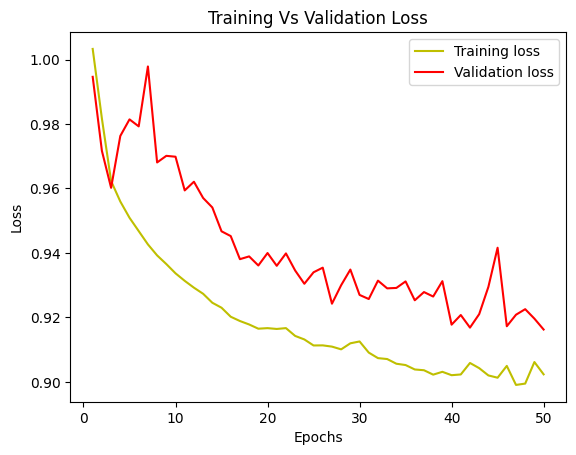

In [44]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label = "Validation loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

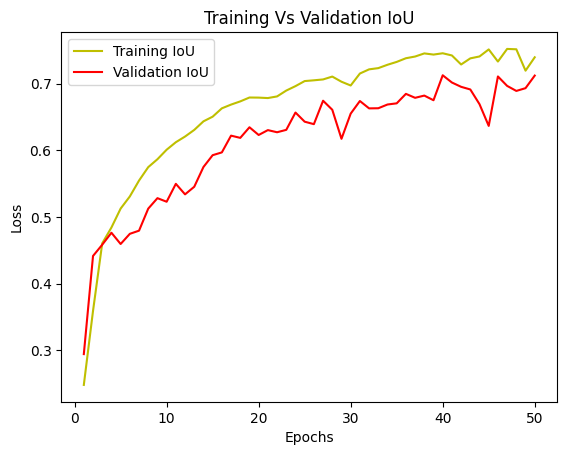

In [45]:
jaccard_coef = history.history['jaccard_coef']
val_jaccard_coef = history.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [46]:
model_history.params

{'verbose': 1, 'epochs': 50, 'steps': 51}

In [47]:
y_pred = model.predict(X_test)

5/5 [==============================] - 6s 55ms/step


In [48]:
print(len(y_pred))

142


In [49]:
print(y_pred.shape)

(142, 256, 256, 6)


In [50]:
print(y_pred)

[[[[1.39311133e-02 7.20079005e-01 1.03689514e-01 1.19759925e-01
    4.12197225e-02 1.32077944e-03]
   [9.33058001e-03 7.70671606e-01 1.25708297e-01 7.17470944e-02
    2.18687356e-02 6.73626608e-04]
   [9.64319520e-03 7.01251090e-01 1.70951828e-01 9.05874446e-02
    2.66896989e-02 8.76825943e-04]
   ...
   [2.81636207e-03 3.30560207e-01 5.46726249e-02 4.78807122e-01
    1.31344289e-01 1.79946946e-03]
   [5.60072390e-03 3.62560898e-01 7.42413998e-02 4.43523198e-01
    1.09348454e-01 4.72539663e-03]
   [1.72919370e-02 3.81991863e-01 1.06673963e-01 3.16941351e-01
    1.58481002e-01 1.86198950e-02]]

  [[6.84972294e-03 7.75889754e-01 9.04189795e-02 1.04683407e-01
    2.19169054e-02 2.41365167e-04]
   [6.72449067e-04 8.38076472e-01 8.74627978e-02 6.60745576e-02
    7.67683005e-03 3.68521760e-05]
   [7.83179770e-04 7.64071763e-01 1.32927224e-01 9.23286751e-02
    9.83616058e-03 5.30686339e-05]
   ...
   [1.26741608e-04 2.84698576e-01 2.56189294e-02 6.25365198e-01
    6.40662611e-02 1.24281782

In [51]:
y_pred_argmax = np.argmax(y_pred, axis = 3)

In [52]:
len(y_pred_argmax)

142

In [53]:
y_test_argmax = np.argmax(y_test, axis = 3)

In [ ]:
print(y_pred_argmax)

In [56]:
print(y_pred_argmax.shape)

(142, 256, 256)


In [69]:
rand_test = np.random.randint(1, len(y_test))
print(y_test[rand_test, 1, 1, :])
print(y_test_argmax[rand_test, 1, 1])
print(y_pred[rand_test, 1, 1, :])
print(y_pred_argmax[rand_test, 1, 1])

[0. 1. 0. 0. 0. 0.]
1
[1.2166097e-03 9.8188305e-01 1.4052504e-02 2.1015648e-03 7.2371034e-04
 2.2609835e-05]
1


1/1 [==============================] - 0s 20ms/step


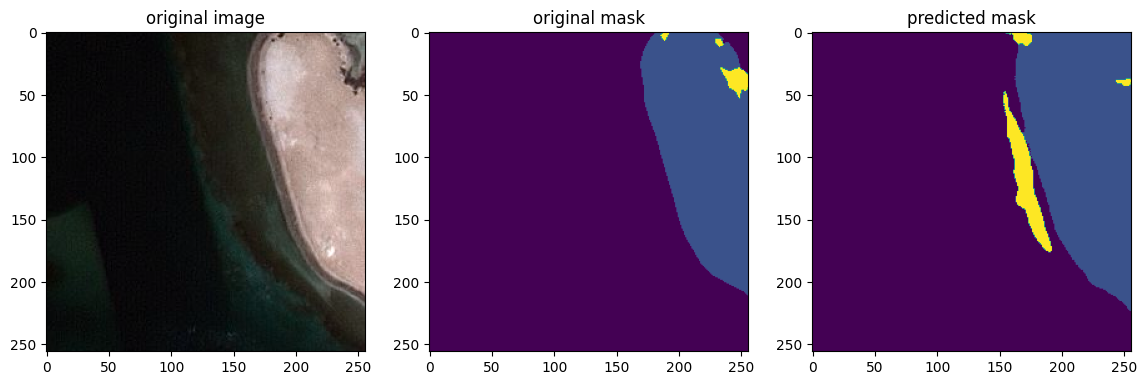

In [98]:
test_image_number = np.random.randint(0, len(X_test))
test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]
test_image_input = np.expand_dims(test_image, 0)
prediction = model.predict(test_image_input)
#prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]
plt.figure(figsize = (14, 8))
plt.subplot(131)
plt.title("original image")
plt.imshow(test_image)
plt.subplot(132)
plt.title("original mask")
plt.imshow(ground_truth_image)
plt.subplot(133)
plt.title("predicted mask")
plt.imshow(predicted_image)


In [99]:
model.save("satellite_segmentation")

In [100]:
!ls -lah

total 30M
drwxr-xr-x  1 root root 4.0K Feb  7 20:01  .
drwxr-xr-x  1 root root 4.0K Feb  7 18:40  ..
drwxr-xr-x  4 root root 4.0K Feb  6 14:23  .config
-rw-r--r--  1 root root  30M Feb  7 18:42  Landcover_segmentation.zip
drwxr-xr-x  1 root root 4.0K Feb  6 14:23  sample_data
drwxr-xr-x  4 root root 4.0K Feb  7 20:01  satellite_segmentation
drwxr-xr-x 10 root root 4.0K Feb  7 18:43 'Semantic segmentation dataset'
